In [ ]:
import numpy as np  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt  

import tensorflow as tf 
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization  
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 
from tensorflow.keras.models import load_model 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error 

2025-08-31 01:21:21.013942: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-31 01:21:21.599725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 01:21:24.426162: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [ ]:
# Chargement du dataset REFIT
# ------------------------
df = pd.read_csv('../../dataset/refit/CLEAN_House5.csv')  # adapte le chemin

df['Timestamp'] = pd.to_datetime(df['Unix'], unit='s', utc=True)
df.set_index('Timestamp', inplace=True)

# Colonnes
mains = ["Aggregate"]
appliances = ["Appliance4", "Appliance1", "Appliance3"]

In [ ]:
# Split train/test 80/20
# ------------------------
split_idx = int(len(df) * 0.80)
train_data = df.iloc[:split_idx]
test_data  = df.iloc[split_idx:]

print("Taille train:", len(train_data))
print("Taille test :", len(test_data))

Taille train: 5944604
Taille test : 1486151


In [ ]:
# Standardisation
# ------------------------
scalers_total = {}
scalers_appliance = {}

for m in mains:
    scalers_total[m] = StandardScaler().fit(train_data[m].values.reshape(-1, 1))

for a in appliances:
    scalers_appliance[a] = StandardScaler().fit(train_data[a].values.reshape(-1, 1))

train_data_scaled = {m: scalers_total[m].transform(train_data[m].values.reshape(-1, 1)) for m in mains}
test_data_scaled  = {m: scalers_total[m].transform(test_data[m].values.reshape(-1, 1)) for m in mains}

train_appliance_scaled = {a: scalers_appliance[a].transform(train_data[a].values.reshape(-1, 1)) for a in appliances}
test_appliance_scaled  = {a: scalers_appliance[a].transform(test_data[a].values.reshape(-1, 1)) for a in appliances}

In [ ]:
# Création des séquences
# ------------------------
def create_sequences(mains_data, appliances_data, seq_length):
    X, y = [], []
    L = len(mains_data[mains[0]])
    for i in range(L - seq_length):
        X.append([mains_data[m][i:i+seq_length, 0] for m in mains])
        y.append([appliances_data[a][i+seq_length-1, 0] for a in appliances])
    X = np.array(X).transpose((0,2,1))
    y = np.array(y)
    return X, y

seq_length = 10
X_train, y_train = create_sequences(train_data_scaled, train_appliance_scaled, seq_length)
X_test, y_test = create_sequences(test_data_scaled, test_appliance_scaled, seq_length)

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (5944594, 10, 1)
Shape y_train: (5944594, 3)
Shape X_test: (1486141, 10, 1)
Shape y_test: (1486141, 3)


In [ ]:


model = Sequential()
model.add(Input(shape=(seq_length, len(mains))))

# LSTM plus large avec bidirectionnalité pour capturer plus de patterns
model.add(LSTM(256, return_sequences=True))  # Premier LSTM avec return_sequences=True
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Deuxième couche LSTM pour plus de profondeur
model.add(LSTM(128, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Architecture dense optimisée
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Sortie
model.add(Dense(len(appliances)))

# --------------------------------------------------------
# Optimizer optimisé pour gros dataset
# --------------------------------------------------------
opt = Adam(
    learning_rate=0.002,      # Learning rate plus élevé au départ
    beta_1=0.9,               # Momentum standard
    beta_2=0.999,             # RMSprop standard
    epsilon=1e-7,             # Stabilité numérique
    clipnorm=1.5              # Gradient clipping plus permissif
)

model.compile(
    optimizer=opt,
    loss='huber',             # Robuste aux outliers
    metrics=['mae', 'mse']    # Métriques multiples pour monitoring
)

# --------------------------------------------------------
# Callbacks optimisés pour gros dataset
# --------------------------------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,              # Plus de patience avec gros dataset
    restore_best_weights=True,
    min_delta=0.001           # Delta minimum pour éviter arrêt prématuré
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.6,               # Réduction moins agressive
    patience=8,               # Patience adaptée
    min_lr=1e-6,              # LR minimum plus bas
    verbose=1,
    cooldown=3                # Cooldown pour éviter réductions trop fréquentes
)

model_checkpoint = ModelCheckpoint(
    'best_model_optimized.keras', 
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# --------------------------------------------------------
# Entraînement optimisé
# --------------------------------------------------------
history = model.fit(
    X_train, y_train,
    epochs=80,               # Budget plus large (early stopping contrôle)
    batch_size=512,           # Batch size plus grand pour gros dataset
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    shuffle=True              # Important pour gros dataset
)


2025-08-31 01:22:07.624673: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/80


2025-08-31 01:22:08.630493: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 237783760 exceeds 10% of free system memory.


11611/11611 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1928 - mae: 0.3734 - mse: 0.9503
Epoch 1: val_loss improved from None to 0.20935, saving model to best_model_optimized.keras
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 2209s 190ms/step - loss: 0.1869 - mae: 0.3611 - mse: 0.9185 - val_loss: 0.2093 - val_mae: 0.3950 - val_mse: 1.0189 - learning_rate: 0.0020
Epoch 2/80
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1805 - mae: 0.3501 - mse: 0.8792
Epoch 2: val_loss improved from 0.20935 to 0.19906, saving model to best_model_optimized.keras
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 2137s 184ms/step - loss: 0.1804 - mae: 0.3499 - mse: 0.8805 - val_loss: 0.1991 - val_mae: 0.3864 - val_mse: 0.8974 - learning_rate: 0.0020
Epoch 3/80
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1790 - mae: 0.3474 - mse: 0.8732
Epoch 3: val_loss did not improve from 0.19906
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 2143s 185ms/step - loss: 0.1787 - mae: 0.3470 - mse: 0.8705 - val_loss: 0.2013 - val_mae: 0.3839 

11611/11611 ━━━━━━━━━━━━━━━━━━━━ 2778s 239ms/step - loss: 0.1761 - mae: 0.3429 - mse: 0.8624 - val_loss: 0.1936 - val_mae: 0.3776 - val_mse: 0.8840 - learning_rate: 0.0020
Epoch 22/80
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.1755 - mae: 0.3420 - mse: 0.8573
Epoch 22: val_loss did not improve from 0.19360
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 2810s 242ms/step - loss: 0.1761 - mae: 0.3429 - mse: 0.8600 - val_loss: 0.1950 - val_mae: 0.3768 - val_mse: 0.8989 - learning_rate: 0.0020
Epoch 23/80
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.1771 - mae: 0.3444 - mse: 0.8675
Epoch 23: val_loss did not improve from 0.19360
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 2846s 245ms/step - loss: 0.1787 - mae: 0.3468 - mse: 0.8726 - val_loss: 0.2040 - val_mae: 0.3901 - val_mse: 0.9164 - learning_rate: 0.0020
Epoch 24/80
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.1807 - mae: 0.3490 - mse: 0.8877
Epoch 24: val_loss did not improve from 0.19360
11611/11611 ━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
# Visualisation des courbes d'entraînement
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Ajustement de l'échelle Y pour réduire la marge
y_min = min(min(history.history['loss']), min(history.history['val_loss']))
y_max = max(max(history.history['loss']), max(history.history['val_loss']))
plt.ylim(y_min * 0.995, y_max * 1.005)   # marge réduite à ±0.5%

plt.show()

  

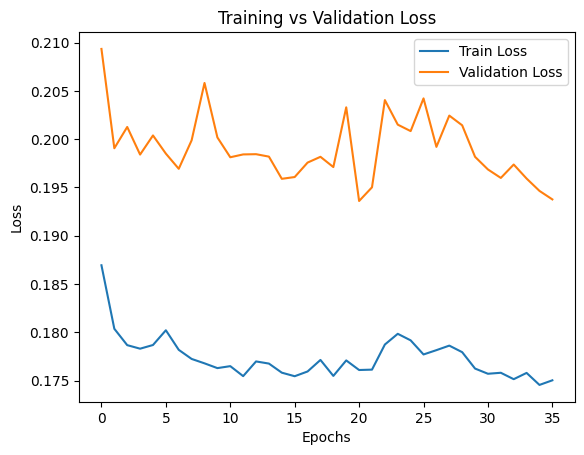

In [ ]:
# Visualisation des courbes d'entraînement
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Ajustement de l'échelle Y pour réduire la marge
y_min = min(min(history.history['loss']), min(history.history['val_loss']))
y_max = max(max(history.history['loss']), max(history.history['val_loss']))
plt.ylim(y_min * 0.995, y_max * 1.005)   # marge réduite à ±0.5%

plt.show()


46442/46442 ━━━━━━━━━━━━━━━━━━━━ 964s 21ms/step


/tmp/ipykernel_35/3103505145.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/envs/nilmtk-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


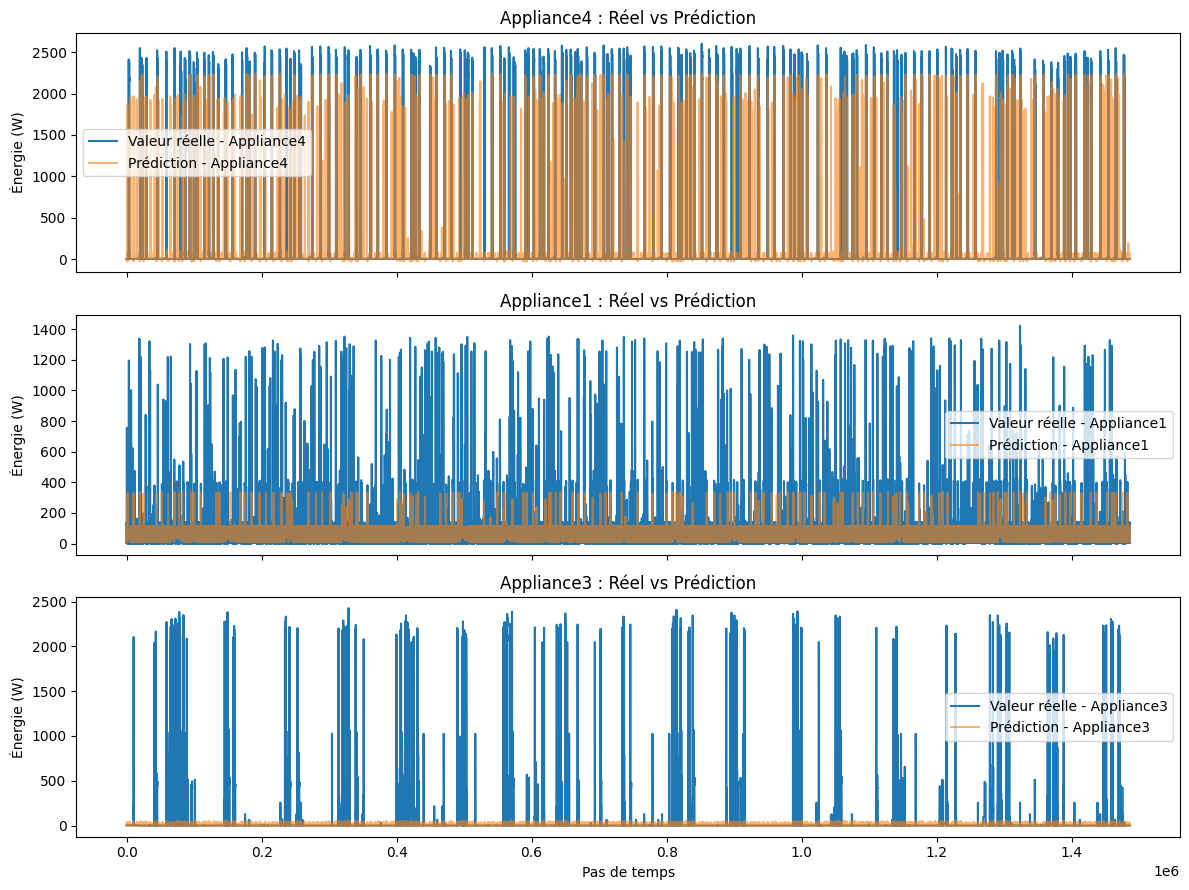

In [14]:
# Évaluation
# ------------------------
best_model = load_model('best_model_optimized.keras')  
predicted = best_model.predict(X_test)  

true = np.zeros_like(y_test)  
pred = np.zeros_like(predicted)  

for j, a in enumerate(appliances):  
    scaler = scalers_appliance[a]  
    true[:, j:j+1] = scaler.inverse_transform(y_test[:, j:j+1])  
    pred[:, j:j+1] = scaler.inverse_transform(predicted[:, j:j+1]) 

n_appliances = len(appliances)
fig, axes = plt.subplots(n_appliances, 1, figsize=(12, 3 * n_appliances), sharex=True)

if n_appliances == 1:
    axes = [axes]

for i, a in enumerate(appliances):
    axes[i].plot(true[:, i], label=f'Valeur réelle - {a}')
    axes[i].plot(pred[:, i], label=f'Prédiction - {a}', alpha=0.6)
    axes[i].legend()
    axes[i].set_title(f'{a} : Réel vs Prédiction')
    axes[i].set_ylabel('Énergie (W)')

axes[-1].set_xlabel('Pas de temps')
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [13]:
# Métriques par appareil
# ------------------------
for i, a in enumerate(appliances):
    mae = mean_absolute_error(true[:, i], pred[:, i]) 
    mse = mean_squared_error(true[:, i], pred[:, i]) 
    rmse = np.sqrt(mse)
    print(f"{a}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, MSE = {mse:.4f}")

Appliance4: MAE = 47.7800, RMSE = 260.0878, MSE = 67645.6562
Appliance1: MAE = 53.3782, RMSE = 67.4766, MSE = 4553.0962
Appliance3: MAE = 47.5249, RMSE = 221.5138, MSE = 49068.3621
